<h1> A geospatial analysis of the spread of Covid-19 in Bangladesh </h1>
    
This notebook aims to explore the district wise spread of Covid-19 in Bangladesh through mapping data visualisations.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd 
import difflib 
import math 

In [2]:
district_geodata = gpd.read_file("../../Map_Data_Bangladesh/bgd_admbnda_adm2_bbs_20180410.shp")

In [3]:
cv19_dist = pd.read_csv('../data/cv19_district_cases_July18.csv')

In [4]:
cv19_dist.replace({'Dhaka (District)':'Dhaka'}, inplace=True)
cv19_dist['District/City'].replace({'Chattogram':'Chittagong'}, inplace=True)

In [5]:
def combine_datasets(df1, district_col1, df2, district_col2):
    ''' Combines dataframes on the district name feature.
    This includes a feature to match names which can vary in spelling when translated to English
    '''
    # Corrects for small variations in English spelling of district names between data frames (e.g Comilla and Cumilla) in preparation for joining
    df1[district_col1] = df1[district_col1].apply(
    lambda x: difflib.get_close_matches(x, df2[district_col2], n=1)[0])
    # Combines the data frames of Covid dataset and district coord dataset
    return df1.join(df2.set_index(district_col2), on=district_col1, how = 'outer') 

In [6]:
df_districts_cv19 = combine_datasets(district_geodata, 'ADM2_EN', cv19_dist, 'District/City')

In [7]:
df_districts_cv19['Log(Cases)'] = df_districts_cv19['Total No of Cases'].apply(lambda x: math.log10(x) if x > 0 else 1E-2)  

[12 25 24  1  1  1]


Text(0.5, 1.0, 'Number of Confirmed Cases by District')

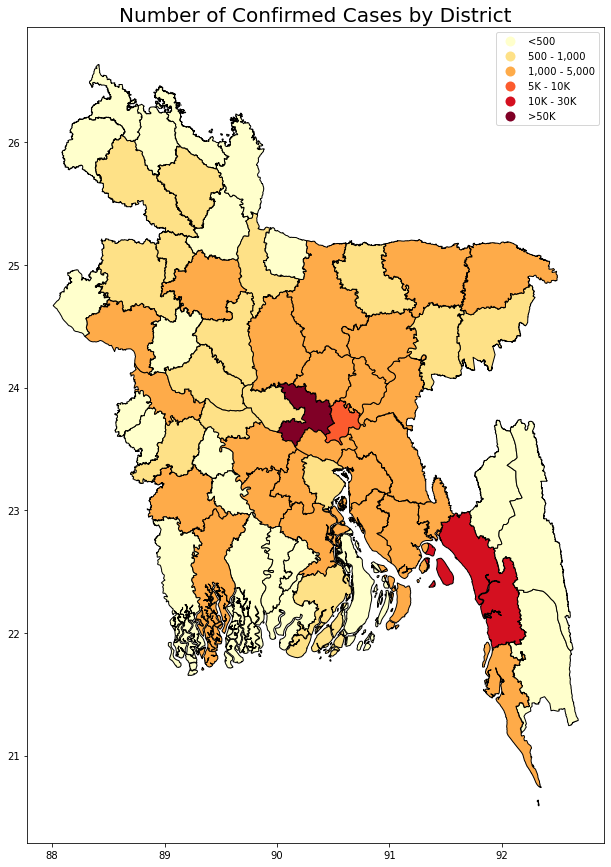

In [8]:
import mapclassify as mc
ud = mc.UserDefined(df_districts_cv19['Log(Cases)'], bins=[2.47,3,3.69,4,4.29,10])
print(ud.counts)                                             
                                               
df_districts_cv19.plot(column='Log(Cases)', figsize=(20,15), zorder=3,
                       edgecolor='k',  
                       cmap='YlOrRd',
                       scheme='UserDefined', 
                       classification_kwds={'bins':[2.69,3, 3.69,4,4.47,10]},
                       legend=True, k=6,
                       legend_kwds={"labels": ['<500', '500 - 1,000', '1,000 - 5,000', 
                                               '5K - 10K', '10K - 30K', '>50K']})
plt.title('Number of Confirmed Cases by District', fontsize=20)

In [9]:
populations_df = pd.read_csv('../data/population_district_wise.csv')

In [10]:
populations_df.head()

,Name,Abbr.,Status,Native,Adm.,Area,Population_1991,Population_2001,Population_2011,Population_2016
0,Barguna,BRG,Dist,?????? ????,BSD,1831,775693,848554,892781,969000
1,Barisal,BRS,Dist,?????? ????,BSD,2785,2207426,2355967,2324310,2583000
2,Bhola,BHO,Dist,???? ????,BSD,3403,1476328,1703117,1776795,1941000
3,Jhalakati,JHA,Dist,??????? ????,BSD,749,666139,694231,682669,741000
4,Patuakhali,PAT,Dist,?????????? ????,BSD,3221,1273872,1460781,1535854,1703000


In [11]:
df_districts_cv19_pop = combine_datasets(df_districts_cv19, 'ADM2_EN', populations_df, 'Name')

In [12]:
df_districts_cv19_pop['Confirmed Cases pt'] = 1000*df_districts_cv19_pop['Total No of Cases']/df_districts_cv19_pop['Population_2016']                                    

Text(0.5, 1.0, 'Confirmed Cases Per Thousand People')

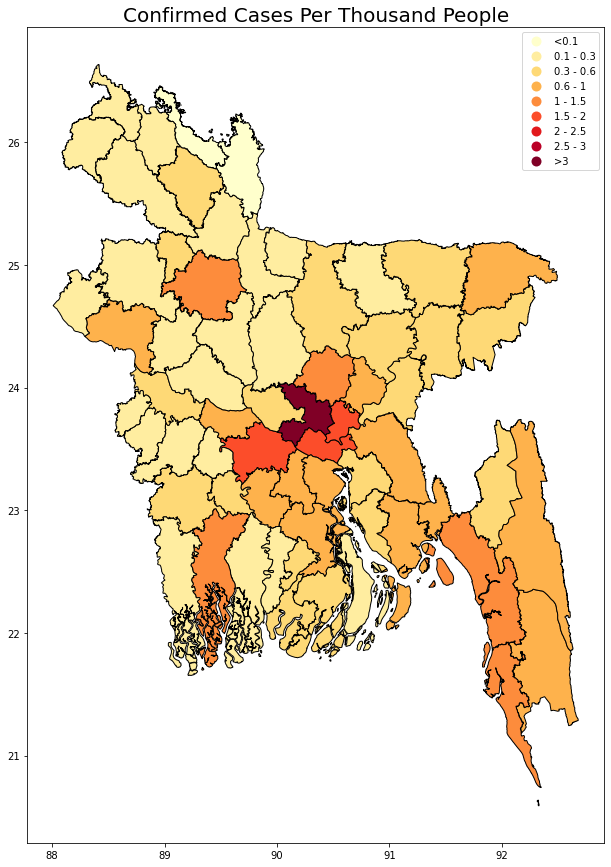

In [13]:
df_districts_cv19_pop.plot(column='Confirmed Cases pt', figsize=(15,15), zorder=3,
                       edgecolor='k',  
                       cmap='YlOrRd',
                       scheme='UserDefined', 
                       classification_kwds={'bins':[0.1,0.3, 0.6,1,1.5,2,2.5,3,10]},
                       legend=True, 
                       legend_kwds={"labels": ['<0.1', '0.1 - 0.3', '0.3 - 0.6', '0.6 - 1',
                                               '1 - 1.5','1.5 - 2', '2 - 2.5', '2.5 - 3', '>3']})
plt.title('Confirmed Cases Per Thousand People', fontsize=20)

In [14]:
from geopandas.tools import geocode

In [20]:
districts = df_districts_cv19_pop.ADM2_EN.values

In [22]:
result = geocode(districts, provider='nominatim', user_agent="TGreen")
result

TypeError: cannot unpack non-iterable NoneType object

In [17]:
#Create map of district and divisional case numbers which will include clorepleth and markers layered for each 

m = folium.Map(
    location=[np.median(df_districts_cv19['lat']),np.median(df_districts_cv19['lon'])],
    zoom_start=7, 
)

layer1=folium.FeatureGroup(name='District Markers', show=False)
layer2=folium.FeatureGroup(name='Division Markers', show=False)

m.add_child(layer1)
m.add_child(layer2)

for index,rows in df_districts_cv19.iterrows():
    if rows['lat'] and rows['lon']:
        folium.Marker([rows['lat'], rows['lon']], popup='District: '+(str(rows['name']))+'\n\nConfirmed cases: '+str(rows['TOTAL']), 
                      icon=folium.Icon(color='orange', icon='info-sign')                     
                     ).add_to(layer1)

for index,rows in df_divisions.iterrows():
    if rows['lat'] and rows['lon']:
        folium.Marker([rows['lat'], rows['lon']], popup='Division: '+(str(rows['geoname']))+'\n\nConfirmed cases: '+str(rows['TOTAL']), 
                      icon=folium.Icon(color='darkpurple', icon='info-sign')                     
                     ).add_to(layer2)
        
folium.Choropleth(
    geo_data = district_geodata,
    name='District Chloropleth',
    data=df_districts_cv19,
    columns=['geoname', 'logtotal'],
    key_on='feature.properties.ADM2_EN',
    legend_name='Confirmed Cases of Covid-19 [log]',
    fill_color='Oranges',
    highlight = True, 
    #bins = [0.0001, math.log10(10),math.log10(25),math.log10(50),math.log10(100),math.log10(200),math.log10(400),math.log10(1000),math.log10(10000),math.log10(50000)]    
).add_to(m)

folium.Choropleth(
    geo_data = division_geodata,
    name='Division Chloropleth',
    data=df_divisions,
    columns=['geoname', 'logtotal'],
    key_on='feature.properties.ADM1_EN',
    legend_name='Confirmed Cases of Covid-19 [log]',
    fill_color='Purples',
    highlight = True, 
    #bins = [0.0001, math.log10(10),math.log10(25),math.log10(50),math.log10(100),math.log10(200),math.log10(500),math.log10(1000),math.log10(5000),math.log10(10000),math.log10(15000)]    
).add_to(m)

folium.LayerControl(collapsed = False).add_to(m)

m.save('Covid19_GeographicDistribution_BD.html')
m

NameError: name 'folium' is not defined